# Hybrid DL Fusion: CNN + LSTM + Transformer + Autoencoder

This notebook implements a state-of-the-art hybrid Deep Learning architecture for Network Intrusion Detection on the NSL-KDD dataset.

## Architecture Overview
The model fuses four powerful deep learning components:
1. **Autoencoder (AE)**: Used for dimensionality reduction and feature extraction (reconstruction auxiliary task).
2. **CNN (1D)**: Extracts local spatial patterns from the feature vector.
3. **LSTM**: Captures sequential dependencies (treating features as a sequence).
4. **Transformer**: Applies self-attention mechanisms to weigh feature importance globally.


## 1. Setup and Imports

In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Add project root to sys.path
project_root = Path("../..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from src.data.datasets import get_dataset, get_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2. Load and Preprocess Data

In [3]:
# Load NSL-KDD Dataset
data_config = {
    "name": "nsl_kdd",
    "classification": "binary",  # Change to 'multiclass' for 5-class classification
    "normalize": "standard",     # Standard scaling is superior for LSTM/Transformer convergence.
                                 # We removed the Sigmoid from the Autoencoder to handle negative values.
    "handle_imbalance": "smote", # balanced training
    "data_dir": str(project_root / "data")
}

print("Loading dataset...")
dataset = get_dataset(**data_config)

X_train = dataset["X_train"]
y_train = dataset["y_train"]
X_val = dataset["X_val"]
y_val = dataset["y_val"]
X_test = dataset["X_test"]
y_test = dataset["y_test"]

print(f"Training Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")

# Create DataLoaders
train_loader, val_loader, test_loader = get_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=128
)


Loading dataset...


Loading NSL-KDD from C:\Users\musab\Projects\NIDS-DL\data\raw\nsl-kdd\train.txt

✓ Loaded 125973 samples, 41 features

✓ Label distribution:
label
Normal    67343
Attack    58630
Name: count, dtype: int64

Encoding 3 categorical columns

✓ Label classes: ['Attack' 'Normal']

✓ Split: Train=88180, Val=12598, Test=25195

Applying smote resampling...

Original class distribution: [41041 47139]

✓ Resampled class distribution: [47139 47139]

✓ Applied standard normalization

✓ Applied standard normalization

Training Shape: (94278, 41)
Validation Shape: (12598, 41)
Test Shape: (25195, 41)


✓ Created DataLoaders (batch_size=128)

## 3. Define Hybrid Model Architecture


In [4]:
class HybridFusionModel(nn.Module):
    def __init__(self, input_dim, num_classes, latent_dim=32):
        super(HybridFusionModel, self).__init__()
        
        # --- Autoencoder Branch ---
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            # nn.Sigmoid() removed because we are using Standard Scaling (values can be negative)
        )
        
        # --- CNN Branch ---
        # Input to CNN will be (Batch, 1, Input_Dim)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate CNN output size to feed into LSTM
        # If input is L, MaxPool(2) reduces it to L/2. Two pooled layers => L/4.
        self.cnn_output_len = input_dim // 4
        
        # --- LSTM Branch ---
        # Input to LSTM: (Batch, Seq_Len, Features)
        # We permute CNN output: (Batch, 64, L/4) -> (Batch, L/4, 64)
        self.lstm = nn.LSTM(
            input_size=64, 
            hidden_size=64, 
            num_layers=2, 
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        # --- Transformer Branch ---
        # Input to Transformer: (Batch, Seq_Len, Feature_Dim)
        # LSTM output: (Batch, L/4, 64 * 2)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, # 64*2 for Bidirectional LSTM
            nhead=4,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        
        # --- Fusion & Classifier ---
        # We will concatenate:
        # 1. Latent Vector from AE (Dim: latent_dim)
        # 2. Global Max Pooling of Transformer Output (Dim: 128)
        
        self.fc = nn.Sequential(
            nn.Linear(128 + latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # 1. Autoencoder Path
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        
        # 2. CNN Path
        # Reshape for Conv1D: (Batch, Channels, Length)
        x_cnn = x.unsqueeze(1)
        cnn_out = self.cnn(x_cnn) # Output: (Batch, 64, L/4)
        
        # 3. LSTM Path
        # Permute for LSTM: (Batch, Seq_Len, Features)
        lstm_in = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(lstm_in) # Output: (Batch, L/4, 128)
        
        # 4. Transformer Path
        trans_out = self.transformer(lstm_out)
        
        # Global Pooling (Max over sequence length)
        # trans_out: (Batch, Seq_Len, 128)
        pooled_features, _ = torch.max(trans_out, dim=1)
        
        # 5. Fusion
        combined = torch.cat((pooled_features, latent), dim=1)
        
        # 6. Classification
        logits = self.fc(combined)
        
        return logits, reconstruction


## 4. Training Setup

In [5]:
# Hyperparameters
INPUT_DIM = X_train.shape[1]
NUM_CLASSES = 2 # Binary
LEARNING_RATE = 0.001
EPOCHS = 20 # Increased Epochs for convergence
RECON_LOSS_WEIGHT = 0.1 # Reduced weight for auxiliary reconstruction loss

# Initialize Model
model = HybridFusionModel(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
model = model.to(device)

# Loss Functions
# Weighted Loss to combat False Negatives (Class 1)
weights = torch.tensor([1.0, 3.0]).to(device)
criterion_cls = nn.CrossEntropyLoss(weight=weights)

criterion_recon = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)


HybridFusionModel(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=41, bias=True)
  )
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (tran

## 5. Training Loop

In [6]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_cls = 0
    total_recon = 0
    correct = 0
    samples = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits, reconstruction = model(X)
        
        # Calculate losses
        loss_cls = criterion_cls(logits, y)
        loss_recon = criterion_recon(reconstruction, X)
        
        # Combined loss
        loss = loss_cls + (RECON_LOSS_WEIGHT * loss_recon)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item() * X.size(0)
        total_cls += loss_cls.item() * X.size(0)
        total_recon += loss_recon.item() * X.size(0)
        
        _, preds = torch.max(logits, 1)
        correct += (preds == y).sum().item()
        samples += X.size(0)
        
    return total_loss / samples, total_cls / samples, total_recon / samples, correct / samples

def validate_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    samples = 0
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits, reconstruction = model(X)
            
            loss_cls = criterion_cls(logits, y)
            loss_recon = criterion_recon(reconstruction, X)
            loss = loss_cls + (RECON_LOSS_WEIGHT * loss_recon)
            
            total_loss += loss.item() * X.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == y).sum().item()
            samples += X.size(0)
            
    return total_loss / samples, correct / samples


In [7]:
print("Starting Training...")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    train_loss, t_cls, t_rcn, train_acc = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} (Cls: {t_cls:.4f}, Rec: {t_rcn:.4f}) | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    print("-" * 50)


Starting Training...
Epoch 1/20
Train Loss: 0.1049 (Cls: 0.0603, Rec: 0.4457) | Acc: 0.9666
Val Loss: 0.0597 | Acc: 0.9863
--------------------------------------------------
Epoch 2/20
Train Loss: 0.0508 (Cls: 0.0243, Rec: 0.2650) | Acc: 0.9866
Val Loss: 0.0418 | Acc: 0.9842
--------------------------------------------------
Epoch 3/20
Train Loss: 0.0419 (Cls: 0.0208, Rec: 0.2103) | Acc: 0.9887
Val Loss: 0.0350 | Acc: 0.9917
--------------------------------------------------
Epoch 4/20
Train Loss: 0.0362 (Cls: 0.0184, Rec: 0.1775) | Acc: 0.9899
Val Loss: 0.0291 | Acc: 0.9899
--------------------------------------------------
Epoch 5/20
Train Loss: 0.0319 (Cls: 0.0174, Rec: 0.1454) | Acc: 0.9908
Val Loss: 0.0265 | Acc: 0.9899
--------------------------------------------------
Epoch 6/20
Train Loss: 0.0291 (Cls: 0.0169, Rec: 0.1216) | Acc: 0.9908
Val Loss: 0.0310 | Acc: 0.9843
--------------------------------------------------
Epoch 7/20
Train Loss: 0.0262 (Cls: 0.0156, Rec: 0.1060) | Ac

## 6. Evaluation Results

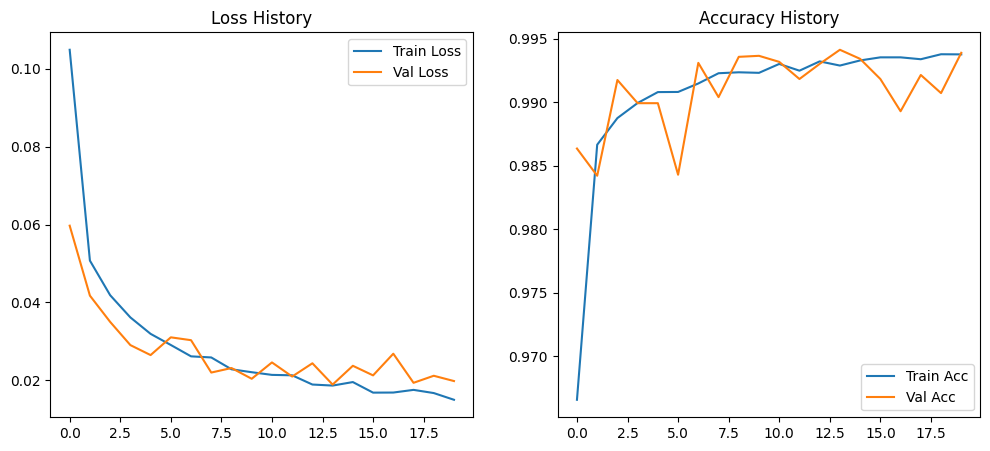

In [8]:
# Plot History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy History')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.99      0.63     11726
           1       0.63      0.01      0.03     13469

    accuracy                           0.47     25195
   macro avg       0.55      0.50      0.33     25195
weighted avg       0.56      0.47      0.31     25195



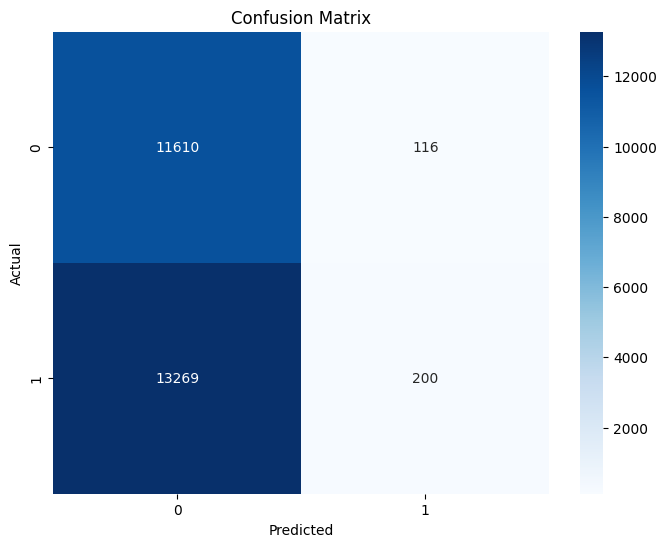

In [9]:
# Detailed Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits, _ = model(X)
        
        # Softmax for Probability Check
        probs = torch.softmax(logits, dim=1)
        
        # Aggressive Threshold: Call it an attack if probability > 0.4
        # Since we weighted the loss, argmax (0.5) might still be fine, 
        # but let's stick to standard argmax first to see the effect of weights.
        _, preds = torch.max(logits, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
